In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import time

In [21]:
FILE_PATH_HARD = "sudoku_datasets/sudoku_hard.csv"
FILE_PATH_MED = "sudoku_datasets/sudoku_medium.csv"
FILE_PATH_EASY = "sudoku_datasets/sudoku_easy.csv"

In [ ]:
def puzzle_to_grid(puzzle_str):
    return np.array([int(ch) if ch.isdigit() else 0 for ch in puzzle_str]).reshape(9, 9)

def similarity_score(p1, p2):
    return sum(a == b for a, b in zip(p1, p2))

def get_top_k_weighted(query, df, k=5):
    df_filtered = df[df['puzzle'] != query]
    sims = df_filtered['puzzle'].apply(lambda p: similarity_score(query, p))
    top_idx = sims.nlargest(k).index
    return list(zip(df_filtered.loc[top_idx, 'solution'], sims.loc[top_idx]))

def vote_weighted_prediction(query_puzzle, df, k=5):
    return puzzle_to_grid(query_puzzle), puzzle_to_grid(query_puzzle), get_top_k_weighted(query_puzzle, df, k)

def clear_all_votes(grid, original_grid):
    grid[original_grid == 0] = 0
    return grid

def is_valid(grid, r, c, num):
    if num in grid[r, :] or num in grid[:, c]:
        return False
    br, bc = 3*(r//3), 3*(c//3)
    return num not in grid[br:br+3, bc:bc+3]

def refine_with_constraints(grid):
    changed = True
    while changed:
        changed = False
        for i in range(9):
            for j in range(9):
                if grid[i, j] == 0:
                    candidates = [n for n in range(1, 10) if is_valid(grid, i, j, n)]
                    if len(candidates) == 1:
                        grid[i, j] = candidates[0]
                        changed = True
    return grid

def get_candidates(grid):
    cands = {}
    for i in range(9):
        for j in range(9):
            if grid[i, j] == 0:
                cands[(i, j)] = {n for n in range(1, 10) if is_valid(grid, i, j, n)}
    return cands

def apply_naked_twins(grid):
    cands = get_candidates(grid)
    units = []
    for i in range(9):
        units.append([(i, j) for j in range(9)])
        units.append([(j, i) for j in range(9)])
    for bi in range(3):
        for bj in range(3):
            units.append([(3*bi + i, 3*bj + j) for i in range(3) for j in range(3)])
    for unit in units:
        twins = [(u, cands[u]) for u in unit if u in cands and len(cands[u]) == 2]
        for (a, ca), (b, cb) in combinations(twins, 2):
            if ca == cb:
                for u in unit:
                    if u not in (a, b) and u in cands:
                        cands[u] -= ca
    for (i, j), cand in cands.items():
        if len(cand) == 1:
            grid[i, j] = cand.pop()
    return grid

def solve_sudoku_cbr_weighted_clear(query_puzzle, df, k=5):
    original_grid = puzzle_to_grid(query_puzzle)
    # Vote fill
    grid = original_grid.copy()
    top_cases = get_top_k_weighted(query_puzzle, df, k)
    for i in range(9):
        for j in range(9):
            if grid[i, j] == 0:
                bucket = []
                for sol_str, sim in top_cases:
                    digit = int(sol_str[i*9 + j])
                    bucket.extend([digit] * sim)
                if bucket:
                    grid[i, j] = Counter(bucket).most_common(1)[0][0]
    grid = clear_all_votes(grid, original_grid)
    grid = refine_with_constraints(grid)
    grid = apply_naked_twins(grid)
    return ''.join(str(x) for x in grid.flatten())

df_easy = pd.read_csv(FILE_PATH_EASY)
df_med  = pd.read_csv(FILE_PATH_MED)
df_hard = pd.read_csv(FILE_PATH_HARD)
df_all  = pd.concat([df_easy, df_med, df_hard], ignore_index=True)

k = 5
for name, df_sub in [('Easy', df_easy), ('Medium', df_med), ('Hard', df_hard)]:
    solved = 0
    total = len(df_sub)
    acc_sum = 0
    for puzzle, solution in zip(df_sub['puzzle'], df_sub['solution']):
        pred = solve_sudoku_cbr_weighted_clear(puzzle, df_all, k)
        correct = sum(a == b for a, b in zip(pred, solution))
        acc_sum += correct
        if correct == 81:
            solved += 1
    print(f"{name} (k={k}): Mean cell accuracy={acc_sum/(total*81):.3f}, Solved={solved}/{total}")


Easy (k=5): Mean cell accuracy=0.365, Solved=14/1000
Medium (k=5): Mean cell accuracy=0.319, Solved=0/1000
Hard (k=5): Mean cell accuracy=0.302, Solved=0/1000


In [54]:
df_easy = pd.read_csv(FILE_PATH_EASY)
df_med  = pd.read_csv(FILE_PATH_MED)
df_hard = pd.read_csv(FILE_PATH_HARD)
df_all  = pd.concat([df_easy, df_med, df_hard], ignore_index=True)

k = 5  

def evaluate_solver(df_sub, df_casebase, solver_fn, k):
    total = len(df_sub)
    accs = []
    solved_count = 0
    start = time.time()
    for puzzle, solution in zip(df_sub['puzzle'], df_sub['solution']):
        pred = solver_fn(puzzle, df_casebase, k)
        correct = sum(a == b for a, b in zip(pred, solution))
        accs.append(correct / 81)
        if correct == 81:
            solved_count += 1
    duration = time.time() - start
    return {
        'MeanAcc': np.mean(accs),
        'PctSolved': solved_count / total * 100,
        'TimePerPuzzle': duration / total,
        'SolvedCount': solved_count,
        'Total': total
    }

results = []
for name, df_sub in [('Easy', df_easy), ('Medium', df_med), ('Hard', df_hard)]:
    stats = evaluate_solver(df_sub, df_all, solve_sudoku_cbr_weighted_clear, k)
    stats['Dataset'] = name
    stats['k'] = k
    results.append(stats)

results_df = pd.DataFrame(results)[['Dataset', 'k', 'MeanAcc', 'PctSolved', 'TimePerPuzzle', 'SolvedCount', 'Total']]



In [55]:
results_df

,Dataset,k,MeanAcc,PctSolved,TimePerPuzzle,SolvedCount,Total
0,Easy,5,0.364815,1.4,0.016791,14,1000
1,Medium,5,0.318691,0.0,0.015378,0,1000
2,Hard,5,0.301506,0.0,0.015355,0,1000


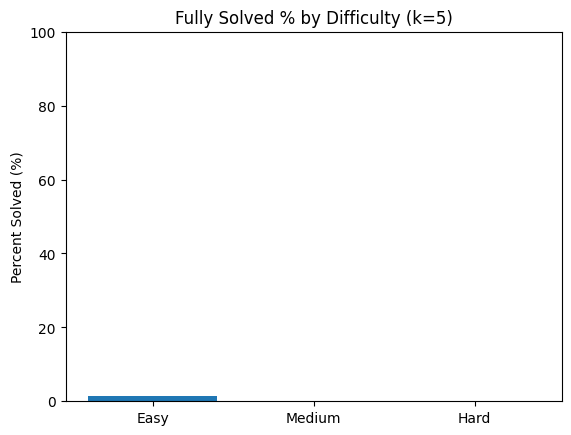

In [48]:

plt.bar(results_df['Dataset'], results_df['PctSolved'], color=['C0','C1','C2'])
plt.ylabel('Percent Solved (%)')
plt.title(f'Fully Solved % by Difficulty (k={k})')
plt.ylim(0, 100)
plt.show()

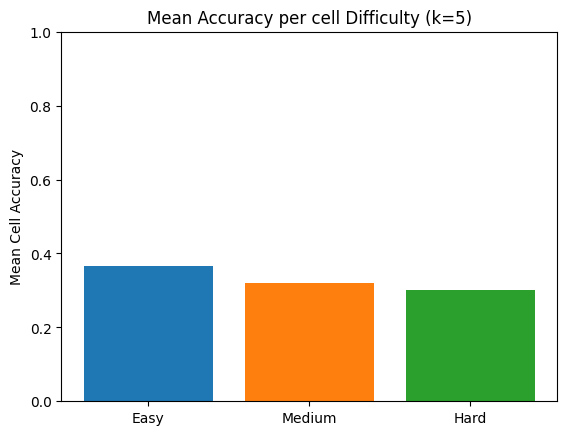

In [50]:

plt.bar(results_df['Dataset'], results_df['MeanAcc'], color=['C0','C1','C2'])
plt.ylabel('Mean Cell Accuracy')
plt.title(f'Mean Accuracy per cell Difficulty (k={k})')
plt.ylim(0, 1)
plt.show()